In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# More on regression

In [27]:
df = pd.read_csv('./data/Irates.csv', index_col='rownames')
df.head()

,r1,r2,r3,r5,r6,r11,r12,r36,r60,r120
rownames,,,,,,,,,,
1,0.325,0.422,0.477,0.549,0.577,0.698,0.720,1.145,1.415,1.825
2,0.322,0.427,0.485,0.555,0.583,0.698,0.718,1.119,1.386,1.824
3,0.326,0.419,0.473,0.543,0.571,0.693,0.715,1.140,1.406,1.817
4,0.318,0.441,0.508,0.583,0.610,0.718,0.737,1.105,1.364,1.804
5,0.302,0.445,0.521,0.606,0.637,0.759,0.780,1.172,1.416,1.815


# Data
We will use the Irates data set in the Ecdat package. This data set has
interests rates for maturities from 1 to 120 months. We will use the first
column, which has the one-month maturity rates, since we want the short
rate.

Let's construct some basic plots for the time series.

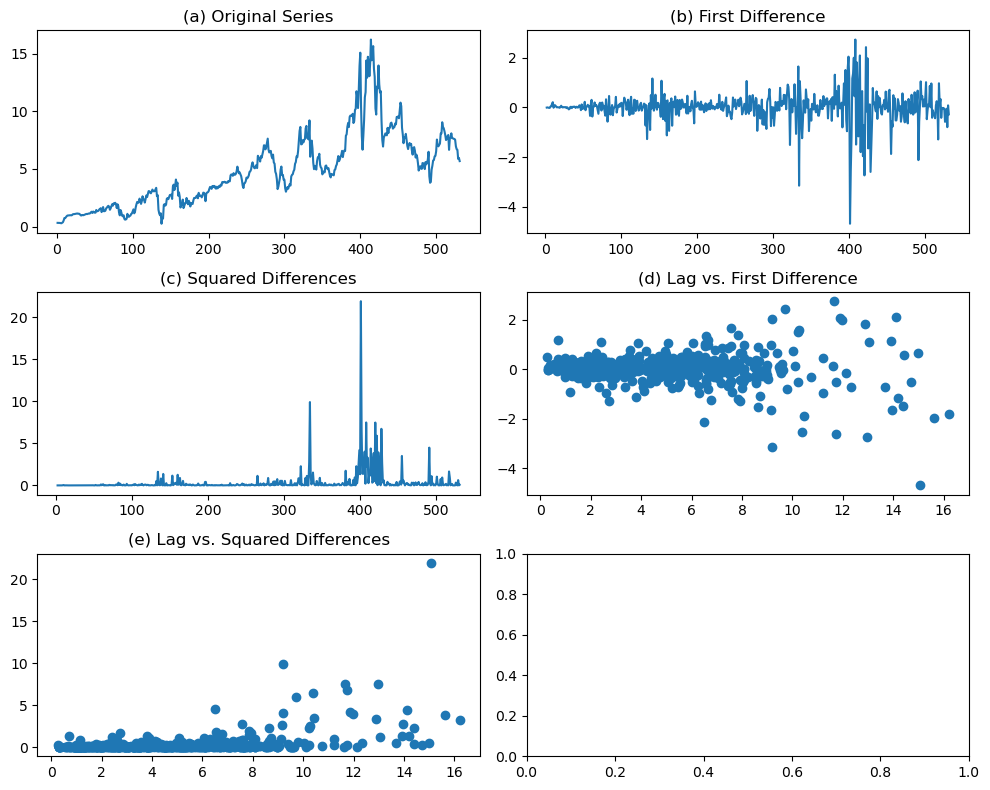

In [44]:
r1 = df['r1']
log_r1 = np.log(r1).dropna()


lag_r1 = r1.shift(1).dropna()
delta_r1 = r1.diff().dropna()


fig, axes = plt.subplots(3, 2, figsize=(10, 8))  

# Plot (a) Original Series
axes[0, 0].plot(r1)
axes[0, 0].set_title('(a) Original Series')

# Plot (b) First Difference
axes[0, 1].plot(delta_r1)
axes[0, 1].set_title('(b) First Difference')

# Plot (c) Squared Differences
axes[1, 0].plot(delta_r1**2)
axes[1, 0].set_title('(c) Squared Differences')

# Plot (d) Scatter plot of Lag vs. First Difference
axes[1, 1].scatter(lag_r1, delta_r1)  # Ensure matching lengths
axes[1, 1].set_title('(d) Lag vs. First Difference')

# Plot (e) Scatter plot of Lag vs. Squared Differences
axes[2, 0].scatter(lag_r1, delta_r1**2)  # Ensure matching lengths
axes[2, 0].set_title('(e) Lag vs. Squared Differences')

plt.tight_layout()
plt.show()

Plot (d) is critical for examining the assumption about the form of μ(r). In a stationary process where the mean level does not change over time, we would expect to see no trend in this scatter plot. Any evident trend could suggest a relationship between the lagged rates and their changes, indicating that the drift might indeed depend on the current rate r.

There is no trend presented in plot (d), so the assumption is valid that the drift term doesn't depend on t.

# Assumption

We assume that the short rate satisfies the stochastic differential equation

$$ dr_t = \mu (t, r_t) dt + \sigma (t, r_t) dW_t$$

where $\mu$ is drift term, $\sigma$ is a volatility function, and $W_t$ is a standard Brownian motion.

We will start with the CKLS model, which assume that

$$ \mu (t, r) = mu(r) = a(\theta - r)$$

for some unknow parameters a and $\theta$, and

$$\sigma (t, r) = \sigma r^{\gamma}$$

In [45]:
from scipy.optimize import curve_fit

5.3275411431274
0.019839132955370802


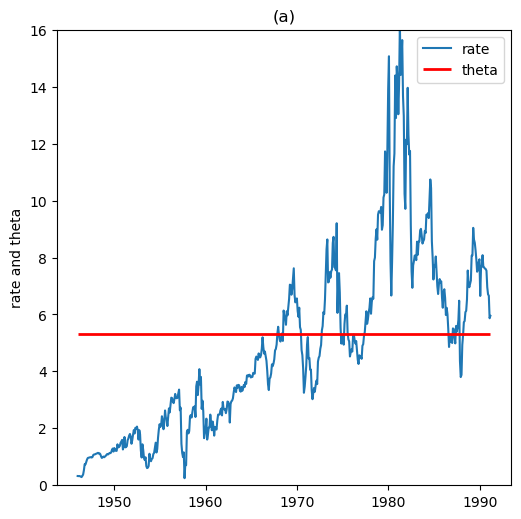

In [52]:
def model_f(lag_r1, a, theta):
    return a*(theta - lag_r1)

params, params_covariance = curve_fit(model_f, lag_r1, delta_r1, p0=[0.01, 5], maxfev=200)
a, theta = params
print(theta)
print(a)
plt.figure(figsize=(10, 10))

# Plot (a)
t = np.linspace(1946, 1991 + 2 / 12, num=len(lag_r1))
plt.subplot(2, 2, 1)
plt.plot(t, lag_r1, label='rate')
plt.hlines(theta, t.min(), t.max(), colors='red', linewidth=2, label='theta')
plt.ylim(0, 16)
plt.ylabel('rate and theta')
plt.title('(a)')
plt.legend()

plt.tight_layout()
plt.show()

In [58]:
print("Params: ", params)
print("Covariance: ")
print(params_covariance)

Params:  [0.01983913 5.32754114]
Covariance: 
[[ 6.75655967e-05 -1.73348622e-03]
 [-1.73348622e-03  1.79483580e+00]]


In [74]:
var = np.array([params_covariance[0,0], params_covariance[1,1]])
n = len(lag_r1)
z = 1.96
ci = [[params + np.sqrt(var/n)*z], [params - np.sqrt(var/n)*z]]

In [76]:
print("Theta is {}".format(params[1]))
print("The 95 confidence interval is [{}, {}]".format(ci[1][0][1], ci[0][0][1]))
print("a is {}".format(params[0]))
print("The 95 confidence interval is [{}, {}]".format(ci[1][0][0], ci[0][0][0]))

Theta is 5.3275411431274
The 95 confidence interval is [5.2134818965578456, 5.441600389696954]
a is 0.019839132955370802
The 95 confidence interval is [0.019139321665176033, 0.02053894424556557]


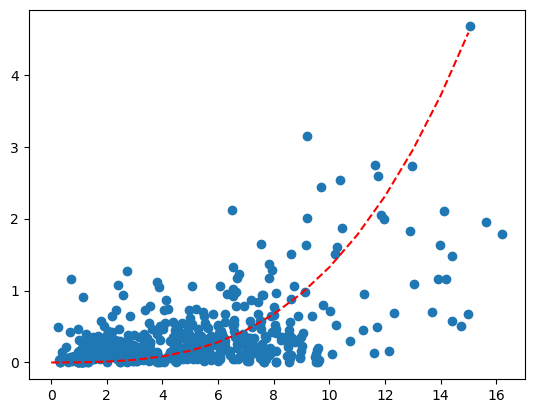

In [120]:
estimated_y = model_f(lag_r1, a, theta)
res = delta_r1 - estimated_y
res_square = res ** 2

def f(lag_r1, a, b):
    return a * lag_r1**b

params, params_cov = curve_fit(f, lag_r1, res_square, p0=[0.2, 1/2])
a, b = params

x_line = np.arange(min(lag_r1), max(lag_r1), 1)
plt.scatter(lag_r1, np.sqrt(res_square))
plt.plot(f(x_line, a, b), '--', color = 'r')
plt.show()

# Response Transformation

This section uses the HousePrices data set in the AER package. This is a
cross-sectional data set on house prices and other features, e.g., the number
of bedrooms of houses in Windsor, Ontario. The data were gathered during
the summer of 1987. 

In [158]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy import stats

In [132]:
HousePrices = pd.read_csv('./data/HousePrices.csv', index_col='rownames')
HousePrices.head()

,price,lotsize,bedrooms,bathrooms,stories,driveway,recreation,fullbase,gasheat,aircon,garage,prefer
rownames,,,,,,,,,,,,
1,42000,5850,3,1,2,yes,no,yes,no,no,1,no
2,38500,4000,2,1,1,yes,no,no,no,no,0,no
3,49500,3060,3,1,1,yes,no,no,no,no,0,no
4,60500,6650,3,1,2,yes,yes,no,no,no,0,no
5,61000,6360,2,1,1,yes,no,no,no,no,0,no


In [136]:
HousePrices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 546 entries, 1 to 546
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   price           546 non-null    int64
 1   lotsize         546 non-null    int64
 2   bedrooms        546 non-null    int64
 3   bathrooms       546 non-null    int64
 4   stories         546 non-null    int64
 5   garage          546 non-null    int64
 6   driveway_yes    546 non-null    bool 
 7   recreation_yes  546 non-null    bool 
 8   fullbase_yes    546 non-null    bool 
 9   gasheat_yes     546 non-null    bool 
 10  aircon_yes      546 non-null    bool 
 11  prefer_yes      546 non-null    bool 
dtypes: bool(6), int64(6)
memory usage: 33.1 KB


In [167]:
categorical_cols = HousePrices.select_dtypes(include=['bool']).columns

HousePrices = pd.get_dummies(HousePrices, columns=categorical_cols, dtype='int')
X = HousePrices.drop(['price'], axis = 1)
y = HousePrices['price']

model = sm.OLS(y, X)
results1 = model.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                              1067.
Date:                Wed, 24 Apr 2024   Prob (F-statistic):                        0.00
Time:                        15:06:07   Log-Likelihood:                         -6034.8
No. Observations:                 546   AIC:                                  1.209e+04
Df Residuals:                     535   BIC:                                  1.214e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
lotsize                                     3.4431      0.339     10.144      0.000       2.776       4.110
bedrooms                                 1095.9263    842.938      1.300      0.194    -559.947    2751.800
bathrooms                                1.402e+04   1466.301      9.561      0.000    1.11e+04    1.69e+04
stories                                  6526.5732    925.283      7.054      0.000    4708.940    8344.206
garage                                   4379.7318    833.106      5.257      0.000    2743.173    6016.291
driveway_yes_True_True_True_True_True    5665.6447   1854.971      3.054      0.002    2021.724    9309.565
recreation_yes_True_True_True_True_True  4659.4642   1896.548      2.457      0.014     933.870    8385.059
fullbase_yes_True_True_True_True_True    5306.1054   1583.810      3.350      0.001    2194.856    8417.355
gasheat_yes_True_True_True_True_True     1.285e+04   3218.757      3.993      0.000    6529.985    1.92e+04
aircon_yes_True_True_True_True_True       1.28e+04   1549.330      8.260      0.000    9754.655    1.58e+04
prefer_yes_True_True_True_True_True      9561.2358   1661.849      5.753      0.000    6296.687    1.28e+04
==============================================================================
Omnibus:                      101.942   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              279.382
Skew:                           0.915   Prob(JB):                     2.15e-61
Kurtosis:                       5.988   Cond. No.                     2.74e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [170]:
y_transformed, lambda_ = stats.boxcox(y)
model_transformed = sm.OLS(y_transformed, X)
results2 = model_transformed.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              1361.
Date:                Wed, 24 Apr 2024   Prob (F-statistic):                        0.00
Time:                        15:08:22   Log-Likelihood:                         -817.88
No. Observations:                 546   AIC:                                      1658.
Df Residuals:                     535   BIC:                                      1705.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
lotsize                                     0.0002   2.41e-05      6.419      0.000       0.000       0.000
bedrooms                                    1.0260      0.060     17.177      0.000       0.909       1.143
bathrooms                                   0.4757      0.104      4.579      0.000       0.272       0.680
stories                                     0.0634      0.066      0.967      0.334      -0.065       0.192
garage                                     -0.1750      0.059     -2.964      0.003      -0.291      -0.059
driveway_yes_True_True_True_True_True       1.4449      0.131     10.992      0.000       1.187       1.703
recreation_yes_True_True_True_True_True    -0.1877      0.134     -1.397      0.163      -0.452       0.076
fullbase_yes_True_True_True_True_True       0.2261      0.112      2.015      0.044       0.006       0.447
gasheat_yes_True_True_True_True_True        0.0115      0.228      0.050      0.960      -0.437       0.459
aircon_yes_True_True_True_True_True        -0.1873      0.110     -1.706      0.089      -0.403       0.028
prefer_yes_True_True_True_True_True        -0.2358      0.118     -2.002      0.046      -0.467      -0.004
==============================================================================
Omnibus:                       14.199   Durbin-Watson:                   1.541
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.640
Skew:                          -0.166   Prob(JB):                     7.35e-06
Kurtosis:                       3.964   Cond. No.                     2.74e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [172]:
print("Before the transformation, the AIC is {}".format(results1.aic))
print("After the transformation, the AIC is {}".format(results2.aic))
print("As seen above, after the transformation, the model significantly does better.")

Before the transformation, the AIC is 12091.620560034376
After the transformation, the AIC is 1657.7671149806076
As seen above, after the transformation, the model significantly does better.


# Binary Regression

The goal
here is to investigate how the presence or absence of air conditioning is related
to the other variables.

In [181]:
X = HousePrices.drop(['aircon_yes_True_True_True_True_True'], axis = 1)
y = HousePrices['aircon_yes_True_True_True_True_True']

model_2 = sm.GLM(y, X)
result = model_2.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Generalized Linear Model Regression Results                          
===============================================================================================
Dep. Variable:     aircon_yes_True_True_True_True_True   No. Observations:                  546
Model:                                             GLM   Df Residuals:                      535
Model Family:                                 Gaussian   Df Model:                           10
Link Function:                                Identity   Scale:                         0.16440
Method:                                           IRLS   Log-Likelihood:                -276.29
Date:                                 Wed, 24 Apr 2024   Deviance:                       87.954
Time:                                         15:13:16   Pearson chi2:                     88.0
No. Iterations:                                      3   Pseudo R-squ. (CS):             0.2861
Covariance Type:                             nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
price                                    8.838e-06   1.07e-06      8.260      0.000    6.74e-06    1.09e-05
lotsize                                  -8.26e-06   9.73e-06     -0.849      0.396   -2.73e-05    1.08e-05
bedrooms                                   -0.0477      0.022     -2.160      0.031      -0.091      -0.004
bathrooms                                  -0.0958      0.041     -2.309      0.021      -0.177      -0.014
stories                                     0.0728      0.025      2.886      0.004       0.023       0.122
garage                                      0.0110      0.022      0.491      0.624      -0.033       0.055
driveway_yes_True_True_True_True_True      -0.1004      0.049     -2.049      0.040      -0.196      -0.004
recreation_yes_True_True_True_True_True     0.0461      0.050      0.920      0.357      -0.052       0.144
fullbase_yes_True_True_True_True_True      -0.0152      0.042     -0.362      0.717      -0.098       0.067
gasheat_yes_True_True_True_True_True       -0.3930      0.084     -4.671      0.000      -0.558      -0.228
prefer_yes_True_True_True_True_True        -0.0456      0.045     -1.014      0.310      -0.134       0.043
===========================================================================================================
"""

Price and gas heat are significantly effective to predict if the house has air conditioning. Since it uses the logistics function, we can conclude that if the price of the house is above 62500, it increases the probability of 50% that the house has a air conditioning.
If there is gas heat in the house, there is less probability that there is air conditioning in the house.